# Conclusiones 

In [1]:
#Librerías
from google.colab import drive
import pickle
import joblib
import os
from keras.models import load_model
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve,roc_auc_score,auc

# Modelos


El modelo elegido, es un modelo de redes recurrentes del tipo GRU.

Descargamos el modelo ya entrenado, juntos con los datos, que usaremos para evaluar de nuevo el modelo.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cache_dir = "/content/drive/MyDrive/Practica NLP/"

In [3]:
preprocessed_data_filter = pickle.load(open(cache_dir+"preprocessed_data_filter.pkl",'rb'))
words_train, words_test, labels_train, labels_test = (preprocessed_data_filter['words_train']
                                                      ,preprocessed_data_filter['words_test'], preprocessed_data_filter['labels_train']
                                                      , preprocessed_data_filter['labels_test'])

In [4]:
Tokenizar_features_filter =joblib.load(open(cache_dir+"Tokenizar_features_filter.pkl",'rb'))
words_tokenizer_train, words_tokenizer_test, vocabulary_size= (Tokenizar_features_filter['words_tokenizer_train'],Tokenizar_features_filter['words_tokenizer_test'], Tokenizar_features_filter['vocabulary_size'])

Como he comentado al principio el modelo elegido es la red GRU, a continuación tenemos el resumen del modelo, donde podemos ver las capas utilizadas y el número de neuronas por capa.

In [5]:

gru = load_model(os.path.join(cache_dir, 'gru.h5'))
gru.summary()                                    
                                                                                                                                            

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 32)         2063872   
                                                                 
 gru (GRU)                   (None, 90)                33480     
                                                                 
 dropout (Dropout)           (None, 90)                0         
                                                                 
 dense (Dense)               (None, 1)                 91        
                                                                 
Total params: 2,097,443
Trainable params: 2,097,443
Non-trainable params: 0
_________________________________________________________________


# Métricas

Con respecto a las métricas, ya se han incluido en el apartado de entrenamiento para ayudar a la selección del modelo más adecuado.

A continuación, se genera una función que englobe las métricas para evaluar la calidad del modelo, y además se presenta la curva ROC.

In [6]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    plt.tight_layout()
    plt.show()

In [7]:
def calcula_metricas(confmat):
    
    tn, fp, fn, tp = confmat.ravel()

    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv/(sen+ppv))

    print('ACC: ', acc)
    print('SEN: ', sen)
    print('ESP: ', esp)
    print('PPV: ', ppv)
    print('FSC: ', fsc)
    
    plt.bar(range(5),[acc,sen,esp,ppv,fsc])
    plt.xticks(range(5),['ACC','SEN','ESP','PPV','FSC'])
    plt.plot([-1, 6], [1, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.xlim((-0.5,4.5))
    plt.ylim((0,1.1))
    plt.title('Metricas')
    plt.show()

In [8]:
def evaluation_model(model,train_X,test_X,label_test):
  
  train_predict = model.predict(train_X)
  test_predict = model.predict(test_X)
  prediction_labels_train=np.array(list(map(lambda x: 1 if x >0.5 else 0,train_predict)))
  prediction_labels_test=np.array(list(map(lambda x: 1 if x >0.5 else 0,test_predict)))

  print('Confussion matrix:\n{}'.format(confusion_matrix(labels_test, prediction_labels_test)))
  print('\nClassification report:\n{}'.format(classification_report(labels_test, prediction_labels_test)))
  print('Accuracy score:{}'.format(accuracy_score(labels_test, prediction_labels_test)))
  plot_confusion_matrix(confusion_matrix(labels_test, prediction_labels_test))
  calcula_metricas(confusion_matrix(labels_test, prediction_labels_test))

In [17]:
def ROC_c (X_test,y_test,model,name_model):
  y_pred_keras = model.predict(X_test).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)
  plt.figure()
  plt.plot(fpr_keras, tpr_keras, label=name_model +' (area = {:.3f})'.format(auc_keras))
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.savefig('Log_ROC')
  plt.show()

Confussion matrix:
[[18521  2210]
 [ 2276 11545]]

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     20731
           1       0.84      0.84      0.84     13821

    accuracy                           0.87     34552
   macro avg       0.86      0.86      0.86     34552
weighted avg       0.87      0.87      0.87     34552

Accuracy score:0.8701667052558463


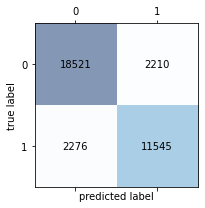

ACC:  0.8701667052558463
SEN:  0.835323059112944
ESP:  0.8933963629347355
PPV:  0.8393311523082515
FSC:  0.8373223092544242


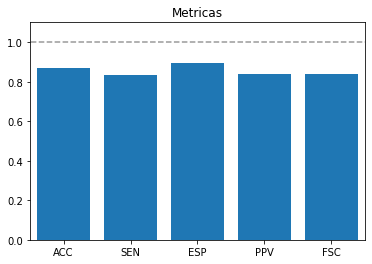

In [9]:
words_train_pdg = sequence.pad_sequences(words_tokenizer_train, maxlen=10000)
words_test_pdg = sequence.pad_sequences(words_tokenizer_test, maxlen=10000)
evaluation_model(gru,words_train_pdg,words_test_pdg,labels_test)

Se puede ver como el modelo funciona bastante bien, ya que para todas las métricas obtenemos unos resultados por encima del 80%, e incluso en alguna de ellas está cerca del 90%.
Las métricas usadas para la evaluación son las siguientes:
- ACC: Es el accuracy, nos mide la tasa de acierto ( 87%)
- SEN: Es la precisión, nos da un indicador de la calidad (84%)
- ESP: Especifidad, porcentaje de casos negativos detectados (89%)
- PPV: recall, exhaustividad, la cantidad que el modelo es capaz de identificar, porcentaje de casos positivos detectados. (84%)
- FSC: F1, combina las medidas de precisión y recall en un sólo valor (84%)

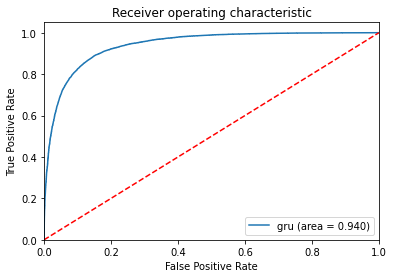

In [18]:
ROC_c (words_test_pdg ,labels_test,gru,'gru')

La curva ROC es una representación gráfica que ilustra la relación entre la sensibilidad y la especificidad para diferentes puntos de corte en un clasificador. No da información de si el modelo es bueno o no distinguiendo dos cosas, en este casos reviews positivas y negativas.
En este caso, el área bajo la curva es de 0.94, y esto nos dice que hay 94% de probabilidad de que el modelo pueda distinguir entre reviews positivas y negativas.

# Conclusiones

El dataset de componía de reviews de productos de belleza y cuidado personal.Los he elegido porque estaban relacionados y no eran muy grandes en tamaño.

Para el estudio se ha tenido que prescindir de parte de los datos por temas computacionales, y está reducción de muestra se ha aprovechado para balancear los datos.

Las reviews positivas eran muy superiores a las negativas, por lo que de forma aleatoria entre las positivas nos hemos quedado con un número tal que las positivas suponían un 60% del dataset y las negativas un 40%. 

El modelo seleccionado es una red neuronal del tipo GRU, con 90 neuronas en esa capa. Incluye además dropout para controlar el overfitting.
El máximo número de palabras considerado ha sido de 10000 y el tamaño del embedding 32.
La capa de salida es una densa con sigmoide como activación.
El número de épocas ha sido solo de 5.

Hemos visto, como la regresión logística obtenida resultados bastante buenos, y la LSTM muy parecidos a la GRU.

Tal vez usando otros hiperparámetros en los modelos, podíamos a ver conseguido otro modelo mejor.

El modelo seleccionado tiene una accuracy del 87% y el area de la curva ROC es del 94%.





